In [5]:
# Download training data

import gdown

url = "https://drive.google.com/file/d/1VC9i5gvZAxCE-RkydXHdanXohY6OGO5P/view?usp=sharing"
output = "data/scrna/schiebinger.npz"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1VC9i5gvZAxCE-RkydXHdanXohY6OGO5P
To: /mnt/hdd/scarv/riemannian-metric-learning-ot/data/scrna/schiebinger.npz
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104M/104M [00:01<00:00, 93.8MB/s]


'data/scrna/schiebinger.npz'

In [1]:
import sys, os
sys.path.append(os.path.join(sys.path[0], "code"))

In [15]:
import pytorch_models as models
import pytorch_samplers as samplers
import pytorch_losses as losses
import pytorch_training as training
import pytorch_utils as utils
import sinkhorn_cnf as cnf
import scrna_exper as scrna
from geomloss import SamplesLoss
from torchdiffeq import odeint as odeint

import importlib
import time
import json
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import torch
import torch.nn as nn
import random
import numpy as np

importlib.reload(models)
importlib.reload(losses)
importlib.reload(samplers)
importlib.reload(training)
importlib.reload(utils)
importlib.reload(scrna)

<module 'scrna_exper' from '/mnt/hdd/scarv/riemannian-metric-learning-ot/code/scrna_exper.py'>

In [3]:
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Import WOT data

data_file = "data/scrna/schiebinger.npz"
data_dict = np.load(data_file, allow_pickle=True)

all_data = data_dict["original_embedding"]
# Rescale the data by factor of 1e-3
all_data *= 1e-3

timestamps = data_dict["sample_labels"]

times = np.unique(timestamps)

subsampled_data_list = []
data_list = []
# Generate training data by randomly selecting 500 observations per time point
for t in list(times):
    data_t = all_data[timestamps == t]
    data_list.append(data_t)
    np.random.shuffle(data_t) # shuffle rows of data_t
    subsampled_data_t = data_t[:500] # keep only first 500 samples
    subsampled_data_list.append(subsampled_data_t)

elapsed time: 977.3058969974518 s.
[-15.         -14.3877551  -13.7755102  -13.16326531 -12.55102041
 -11.93877551 -11.32653061 -10.71428571 -10.10204082  -9.48979592
  -8.87755102  -8.26530612  -7.65306122  -7.04081633  -6.42857143
  -5.81632653  -5.20408163  -4.59183673  -3.97959184  -3.36734694
  -2.75510204  -2.14285714  -1.53061224  -0.91836735  -0.30612245
   0.30612245   0.91836735   1.53061224   2.14285714   2.75510204
   3.36734694   3.97959184   4.59183673   5.20408163   5.81632653
   6.42857143   7.04081633   7.65306122   8.26530612   8.87755102
   9.48979592  10.10204082  10.71428571  11.32653061  11.93877551
  12.55102041  13.16326531  13.7755102   14.3877551   15.        ]


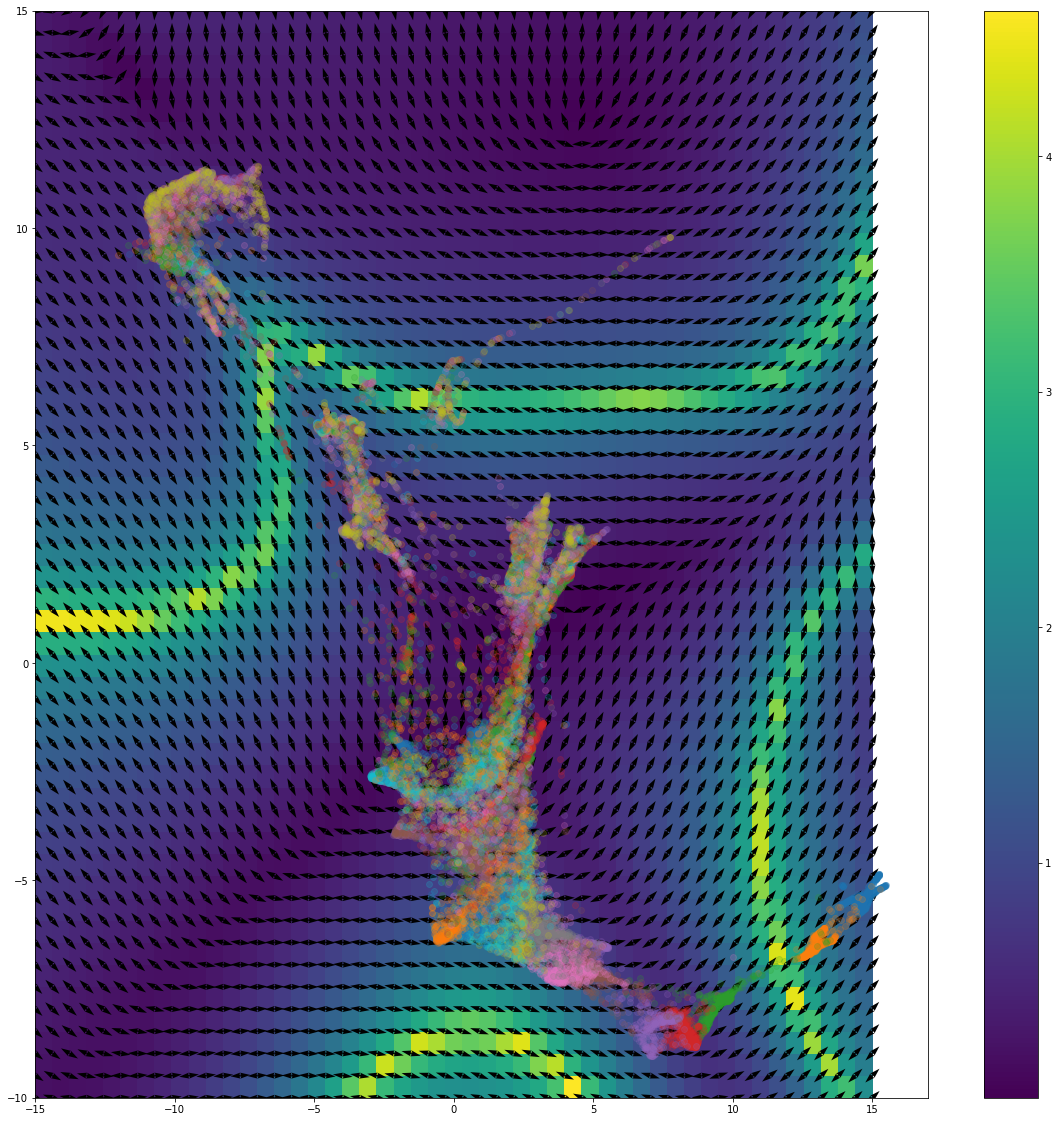

In [36]:
# Learn metric tensor A(x) from Schiebinger data

seed = 0
n_samples = 500
space_dims = 2
scalar_hidden_dims = 128
matrix_hidden_dims = 2048
gp_strength_phi = 0
gp_strength_R = 1e1
fro_reg_strength = 5e2 # was 1e0
identity_reg_strength = 0
lr = 5e-3 # was 1e-2
weight_decay = 1.5e-2
n_epochs_phi = 100
n_epochs_R = 5000 # was 1000
R_model_type = "singlelayer"

t0 = time.time()
scrna_learnedA, phi_list, rho_0_list, rho_1_list = training.twostep_train_wot_model(subsampled_data_list,
                                                                                    n_samples,
                                                                                    scalar_hidden_dims,
                                                                                    matrix_hidden_dims,
                                                                                    fro_reg_strength,
                                                                                    identity_reg_strength,
                                                                                    gp_strength_phi,
                                                                                    gp_strength_R,
                                                                                    lr,
                                                                                    weight_decay,
                                                                                    n_epochs_phi,
                                                                                    n_epochs_R,
                                                                                    seed,
                                                                                    R_model_type
                                                                                   )

t1 = time.time()
print('elapsed time: ' + str(t1-t0) + ' s.')

# Plot eigenvectors of metric
plt.figure(figsize=(20,20))
# Eigs plot params
x_lims = (-15,15)
y_lims = (-10,15)
n = 50
utils.eigs_quiver(scrna_learnedA, n, x_lims, y_lims)
for t in range(len(times)):
    label = "t = " + str(times[t])
    plt.scatter(subsampled_data_list[t][:,0], subsampled_data_list[t][:,1], label=label, alpha=0.2)

In [37]:
# Save model

scrna_learned_path = "trained_models/scrna_learned_params_v3.pt"
torch.save(scrna_learnedA.state_dict(), scrna_learned_path)

In [5]:
# Load pretrained model

space_dims = 2
matrix_hidden_dims = 2048
A_fname = "trained_models/scrna_learned_params_v3.pt" # was 'scrna_pretrained_params.pt'
scrna_learnedA = models.PSDMatrix(space_dims, matrix_hidden_dims).to(device)
scrna_learnedA.load_state_dict(torch.load(A_fname))

<All keys matched successfully>

In [6]:
# Generate list of samplers for all time points

rho_list = samplers.generate_all_eb_samplers(data_list)

In [52]:
# Run experiments without A

k_vals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
A_model = scrna_learnedA
for k in k_vals:
    json_fname = "results/scrna_experiments/k" + str(k) + "_noA.json"
    use_A = False
    W1_vals = scrna.run_experiment(rho_list, json_fname, k, A_model, use_A)
    json_fname_final_tps = "results/scrna_experiments/k" + str(k) + "_noA_final_tps.json"
    W1_vals_final_tps = scrna.run_final_tp_experiment(rho_list, json_fname_final_tps, k, A_model, use_A)

iter 0 loss: tensor(20.7932, device='cuda:0', grad_fn=<AddBackward0>)
iter 100 loss: tensor(0.2321, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [45]:
# Define A_model that always returns the identity matrix

class IdentityMatrix(nn.Module):
    """Just returns the identiy matrix."""

    def __init__(self, space_dims):
        super(IdentityMatrix, self).__init__()
        self.d = space_dims
    def forward(self, x):
        return torch.eye(space_dims, device=device).repeat(x.shape[0], 1, 1)

In [46]:
id_model = IdentityMatrix(2).to(device)

In [8]:
# Run experiments with A

k_vals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
A_model = scrna_learnedA
for k in k_vals:
    json_fname = "results/scrna_experiments/k" + str(k) + "_withA_lambd_1em1.json"
    use_A = True
    W1_vals = scrna.run_experiment(rho_list, json_fname, k, A_model, use_A)
    json_fname_final_tps = "results/scrna_experiments/k" + str(k) + "_withA_lambd_1em1_final_tps.json"
    W1_vals_final_tps = scrna.run_final_tp_experiment(rho_list, json_fname_final_tps, k, A_model, use_A)

iter 0 loss: tensor(112.0409, device='cuda:0', grad_fn=<AddBackward0>)
iter 100 loss: tensor(67.5644, device='cuda:0', grad_fn=<AddBackward0>)
iter 200 loss: tensor(64.1426, device='cuda:0', grad_fn=<AddBackward0>)
iter 300 loss: tensor(60.5795, device='cuda:0', grad_fn=<AddBackward0>)
iter 400 loss: tensor(59.0030, device='cuda:0', grad_fn=<AddBackward0>)
iter 500 loss: tensor(57.6242, device='cuda:0', grad_fn=<AddBackward0>)
iter 600 loss: tensor(53.9709, device='cuda:0', grad_fn=<AddBackward0>)
iter 700 loss: tensor(2.0090, device='cuda:0', grad_fn=<AddBackward0>)
iter 800 loss: tensor(1.3588, device='cuda:0', grad_fn=<AddBackward0>)
iter 900 loss: tensor(1.3611, device='cuda:0', grad_fn=<AddBackward0>)
iter 1000 loss: tensor(1.1946, device='cuda:0', grad_fn=<AddBackward0>)
iter 1100 loss: tensor(1.2548, device='cuda:0', grad_fn=<AddBackward0>)
iter 1200 loss: tensor(1.2682, device='cuda:0', grad_fn=<AddBackward0>)
iter 1300 loss: tensor(1.1842, device='cuda:0', grad_fn=<AddBackward

KeyboardInterrupt: 

In [54]:
# Run experiments with identity matrix as A

k_vals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
A_model = id_model
for k in k_vals:
    json_fname = "results/scrna_experiments/k" + str(k) + "_withIdentityA_lambd_1em1.json"
    use_A = True
    W1_vals = scrna.run_experiment(rho_list, json_fname, k, A_model, use_A)
    json_fname_final_tps = "results/scrna_experiments/k" + str(k) + "_withIdentityA_lambd_1em1_final_tps.json"
    W1_vals_final_tps = scrna.run_final_tp_experiment(rho_list, json_fname_final_tps, k, A_model, use_A)

iter 0 loss: tensor(11.3961, device='cuda:0', grad_fn=<AddBackward0>)
iter 100 loss: tensor(0.9446, device='cuda:0', grad_fn=<AddBackward0>)
iter 200 loss: tensor(0.8908, device='cuda:0', grad_fn=<AddBackward0>)
iter 300 loss: tensor(0.8827, device='cuda:0', grad_fn=<AddBackward0>)
iter 400 loss: tensor(1.0867, device='cuda:0', grad_fn=<AddBackward0>)
iter 500 loss: tensor(0.8674, device='cuda:0', grad_fn=<AddBackward0>)
iter 600 loss: tensor(0.7319, device='cuda:0', grad_fn=<AddBackward0>)
iter 700 loss: tensor(0.7696, device='cuda:0', grad_fn=<AddBackward0>)
iter 800 loss: tensor(0.6520, device='cuda:0', grad_fn=<AddBackward0>)
iter 900 loss: tensor(0.5244, device='cuda:0', grad_fn=<AddBackward0>)
iter 1000 loss: tensor(0.6618, device='cuda:0', grad_fn=<AddBackward0>)
iter 1100 loss: tensor(0.7897, device='cuda:0', grad_fn=<AddBackward0>)
iter 1200 loss: tensor(0.5265, device='cuda:0', grad_fn=<AddBackward0>)
iter 1300 loss: tensor(0.6786, device='cuda:0', grad_fn=<AddBackward0>)
ite

In [ ]:
# CELLS BELOW ARE FOR GENERATING PLOTS FROM EXPERIMENTAL RESULTS

In [13]:
# Compute W1 vals across multiple runs with metric tensor

k_vals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
withA_mean_list = []
withA_std_list = []
use_A = True
n_runs = 10
for k in k_vals:
    mean, std = scrna.compute_multiple_runs(rho_list, k, use_A, n_runs)
    withA_mean_list.append(mean)
    withA_std_list.append(std)

In [19]:
withA_mean_list

[0.5609259557243211,
 0.5591428966224549,
 0.6414688887295927,
 0.7131410260496424,
 0.7793892648562323,
 0.9769072557749652,
 1.0018613978046587,
 1.2045276721544467,
 1.3344498844781802,
 1.506628336755489,
 1.5193777256094705,
 1.87328065027366,
 1.9787862503773632,
 2.1150701358469943,
 2.1577856424176236,
 2.4878252150310813,
 2.6153677976205483,
 3.0426664264959573]

In [20]:
noA_mean_list

[0.5147288744442635,
 0.5148995529104252,
 0.9210575728777111,
 0.8025922258213395,
 0.8802715969340398,
 1.1524503463486906,
 1.1186739889528508,
 1.3456170207897133,
 1.5680256782939268,
 1.6688882991740122,
 1.9672388679003188,
 2.3255172648997724,
 2.4788541833896582,
 2.5651082399106935,
 3.0156062535739347,
 2.578939266749999,
 3.3727469005117476,
 3.9490934095195205]

In [27]:
withA_means = torch.tensor(withA_mean_list)
noA_means = torch.tensor(noA_mean_list)
torch.mean((withA_means[10:] - noA_means[10:])/noA_means[10:])

tensor(-0.1966)

In [14]:
# Compute W1 vals across multiple runs without metric tensor

k_vals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
noA_mean_list = []
noA_std_list = []
use_A = False
n_runs = 10
for k in k_vals:
    mean, std = scrna.compute_multiple_runs(rho_list, k, use_A, n_runs)
    noA_mean_list.append(mean)
    noA_std_list.append(std)

In [16]:
# Compute W1 vals across multiple runs with identity metric tensor
# Need to modify the code for compute_multiple_runs to accomplish this

k_vals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
IdentityA_mean_list = []
IdentityA_std_list = []
use_A = True
n_runs = 10
for k in k_vals:
    mean, std = scrna.compute_multiple_runs(rho_list, k, use_A, n_runs)
    IdentityA_mean_list.append(mean)
    IdentityA_std_list.append(std)

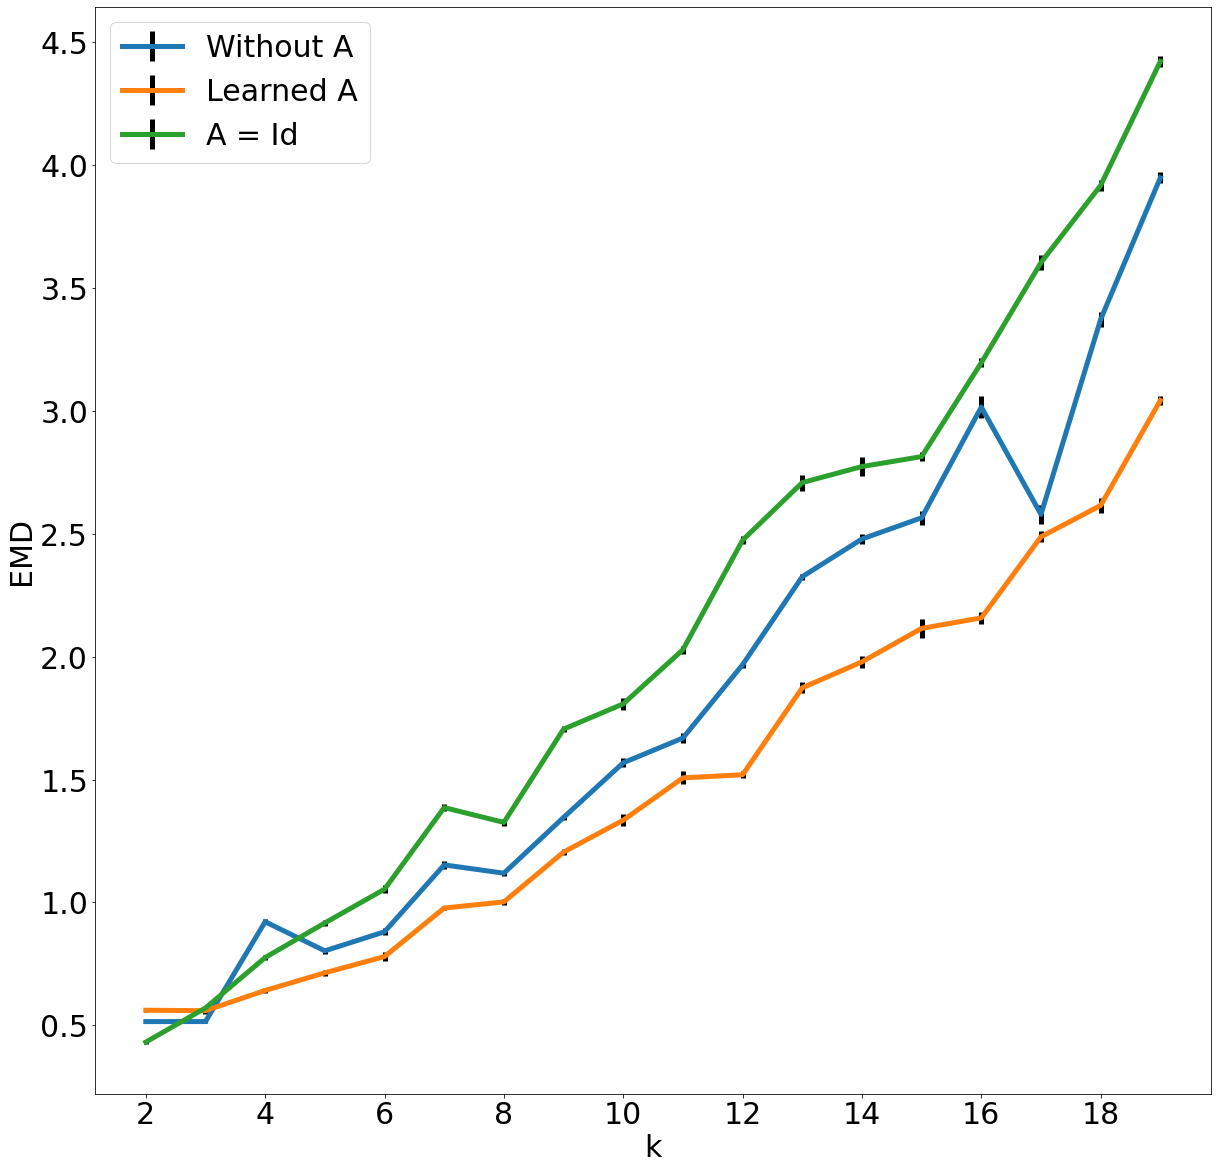

In [17]:
# Generate scRNA W1 comparison (with vs without learned metric tensor)

plt.figure(figsize=(20,20))
plt.errorbar(k_vals, noA_mean_list, yerr = noA_std_list, label="Without A", linewidth=5, ecolor="black")
plt.errorbar(k_vals, withA_mean_list, yerr = withA_std_list, label="Learned A", linewidth=5, ecolor="black")
plt.errorbar(k_vals, IdentityA_mean_list, yerr = IdentityA_std_list, label="A = Id", linewidth=5, ecolor="black")
plt.xlabel("k", size=30)
plt.xticks(k_vals[::2])
plt.ylabel("EMD", size=30)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize=30)
# Save figure
plt.savefig("results/scrna_emd_plot_with_identity.png", dpi=300, bbox_inches="tight")

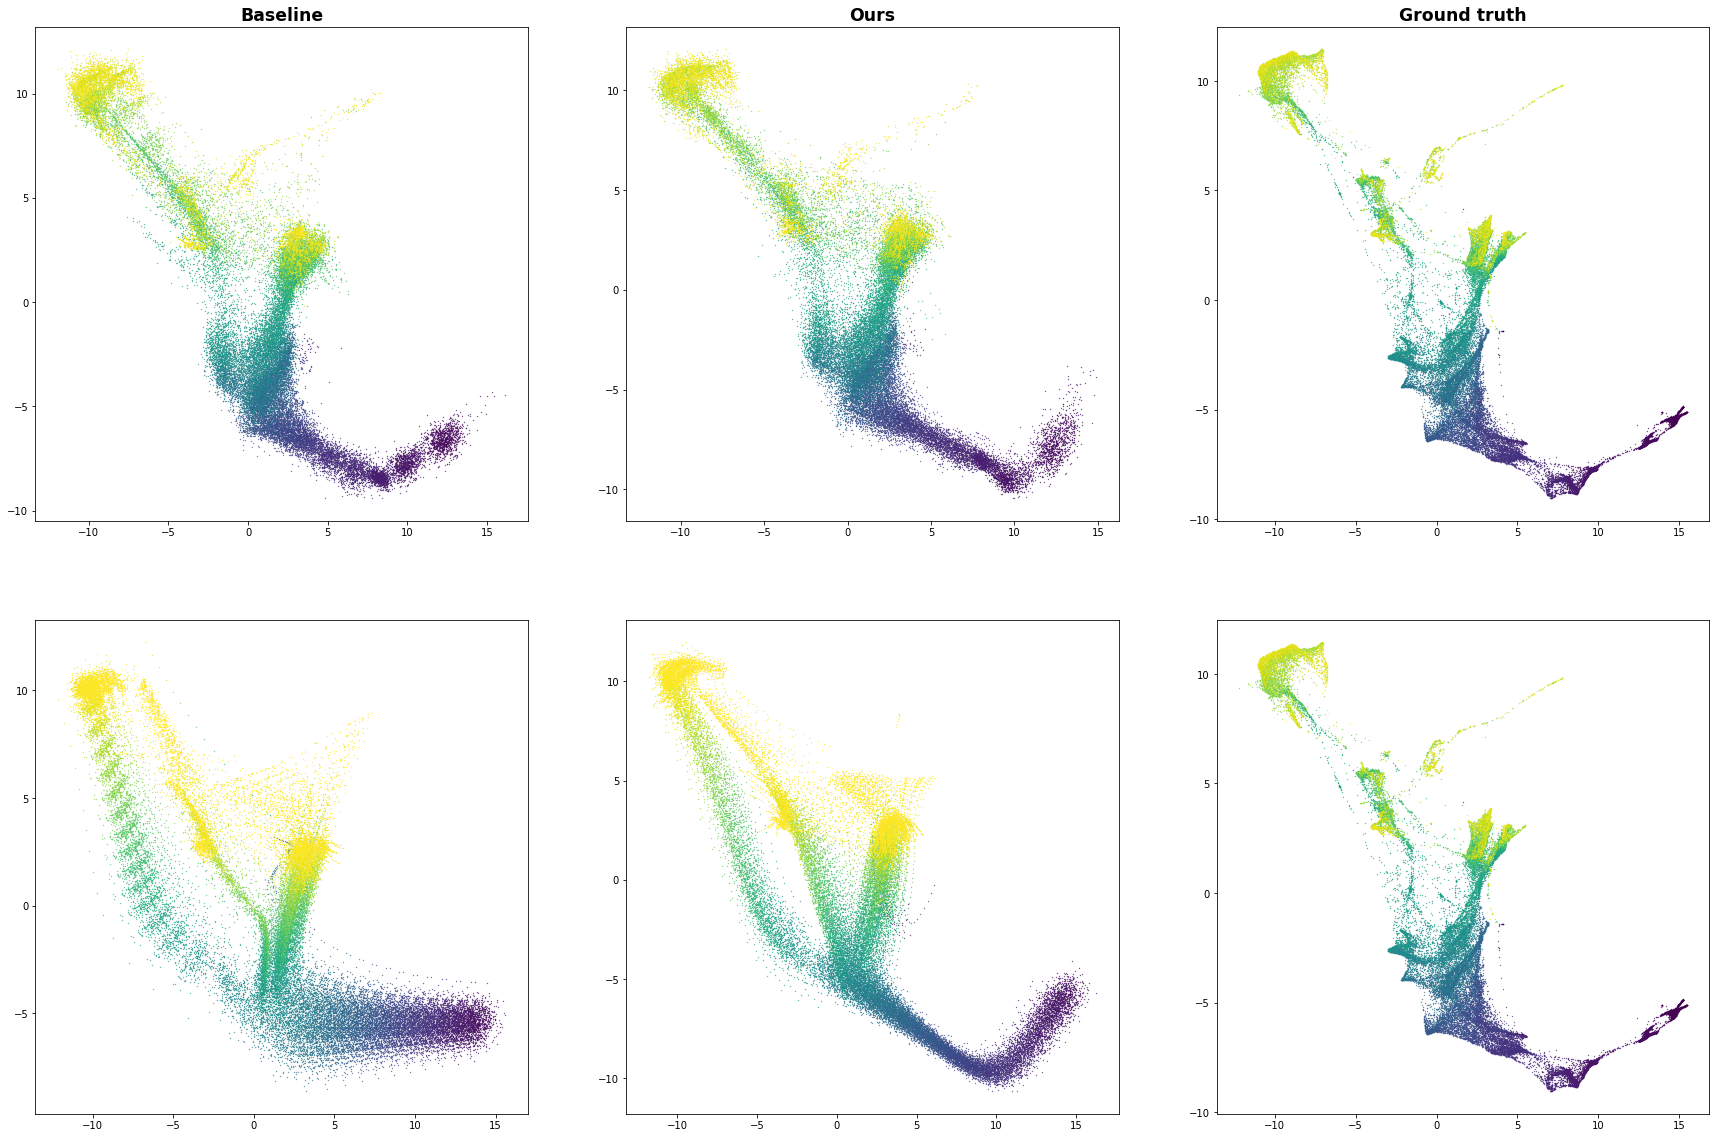

In [18]:
# Generate scRNA trajectory inference plots

fig = plt.figure(figsize=(30,20))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax3 = fig.add_subplot(2,3,3)
ax6 = fig.add_subplot(2,3,6)

# Do k=3 for case where A doesn't help much

k = 3
scrna.visualize_advected_samples_all_times(ax1, rho_list, k, use_A=False)
scrna.visualize_advected_samples_all_times(ax2, rho_list, k, use_A=True)

# Do k=15 for case where A helps a lot

k = 15
scrna.visualize_advected_samples_all_times(ax4, rho_list, k, use_A=False)
scrna.visualize_advected_samples_all_times(ax5, rho_list, k, use_A=True)

# Plot ground truth

norm = colors.Normalize(vmin=0, vmax=len(data_list))
cmap = cm.viridis
for t in range(len(data_list)):
    data = data_list[t][:1000]
    ax3.scatter(data[:,0], data[:,1], color=cmap(norm(t)), s=0.1)
    ax6.scatter(data[:,0], data[:,1], color=cmap(norm(t)), s=0.1)

ax1.set_title("Baseline", fontsize="xx-large", fontweight="bold")
ax2.set_title("Ours", fontsize="xx-large", fontweight="bold")
ax3.set_title("Ground truth", fontsize="xx-large", fontweight="bold")

# Save figure
plt.savefig("results/scrna_traj_plots.png", dpi=300, bbox_inches="tight")